In [1]:
import pickle
import itertools
import random
from collections import Counter
import joblib
import pandas as pd
import numpy as np
import re
from keras import Sequential, optimizers
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM
from keras.utils.np_utils import to_categorical
from nltk.corpus import stopwords
from parsivar import Normalizer
import emoji
import emojies
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [2]:
class CleanText:
    def __init__(self, data_frame, column_name):
        self.cln_list = data_frame[column_name].tolist()
    def __new__(cls, data_frame, column_name,*args, **kwargs):
        data_frame[column_name] = data_frame[column_name].apply(lambda x: x[:400])
        return super().__new__(cls,*args, **kwargs)
    def clean_punctual(self):
        tmp_lst = list(map(lambda x: re.sub(r'https?:\S*', ' ', x), self.cln_list))
        tmp_lst = list(map(lambda x: re.sub(r'@[A-Za-z0-9]\S+', ' ', x), tmp_lst))
        tmp_lst = list(map(lambda x: re.sub(r'[0-9]\S+', ' ', x), tmp_lst))
        self.cln_list = list(map(lambda x: re.sub(r'#|_|:|/d+', ' ', x), tmp_lst))
        return self.cln_list
    def normalize_text(self):
        normalizer = Normalizer(pinglish_conversion_needed=True)
        cln_list = list(map(lambda x: normalizer.normalize(x), self.cln_list))
        self.cln_list = list(map(lambda x: ''.join(ch for ch, _ in itertools.groupby(x)), cln_list))
        return self.cln_list
    def remove_stop_words(self):
        stop_words = set(stopwords.words('RD_persian_01'))
        self.cln_list = list(map(lambda x: ' '.join([w for w in x.split() if not w in stop_words]), self.cln_list))
        return self.cln_list
    def extract_emojis(self):
        self.cln_list = list(map(lambda x: ''.join((' '+c+' ') if c in emoji.UNICODE_EMOJI['en'] else c for c in x), self.cln_list))
        return self.cln_list
    def convert_emojies(self):
        self.cln_list = list(map(lambda x: emojies.replace(x), self.cln_list))
        return self.cln_list
    def frequency_words(self):
        freq = dict(Counter(" ".join(self.cln_list).split()))
        sort_orders = sorted(freq.items(), key=lambda x: x[1], reverse=True)
        sort_orders = sort_orders[:4000]
        # print(sort_orders)
        print(len(sort_orders))
        most_common_word = [i[0] for i in sort_orders]
        most_common_word = set(most_common_word)
        print(most_common_word)
        # print(len(most_common_word))
        self.cln_list = list(map(lambda x: ' '.join([w for w in x.split() if w in most_common_word]), self.cln_list))
        return self.cln_list

In [3]:
class EncodeText:
    def __init__(self,train_text):
        self.train_text = train_text
    def create_tokenizer(self):
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(self.train_text)
        return tokenizer
    def encode_text(self,tokenizer, input_list, max_length):
        # integer encode
        encoded = tokenizer.texts_to_sequences(input_list)
        # pad encoded sequences
        padded = pad_sequences(encoded, maxlen=max_length, padding='post')
        return padded
    def label_encoder(self, tag):
        le = LabelEncoder()
        tmp_tag = le.fit_transform(tag)
        encode_tag = to_categorical(np.array(tmp_tag))
        return encode_tag

In [4]:
# data_df = pd.read_excel('dataset.2.0.0.xlsx', index_col= False)
# fig, ax = plt.subplots()
# ax.hist(data_df['احساس'])
# plt.show()

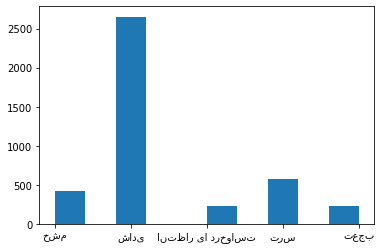

In [4]:
# data_df = pd.read_csv('dataset/comp_dataset2.csv', index_col= False)
data_df = pd.read_excel('dataset/dataset04.xlsx', index_col= False)

fig, ax = plt.subplots()
ax.hist(data_df['tag'])
plt.show()


In [6]:
# data_df = pd.read_excel('1e4_S_01.xlsx', index_col= False)
# fig, ax = plt.subplots()
# ax.hist(data_df['tag'])
# plt.show()


In [5]:
# call_cleantext = CleanText(data_df, 'متن توییت')
call_cleantext = CleanText(data_df, 'caption')
# call_cleantext = CleanText(data_df, 'Text')
get_pun_list = call_cleantext.clean_punctual()
get_ex_emoji = call_cleantext.extract_emojis()
get_emoji_list = call_cleantext.convert_emojies()
get_norm_list = call_cleantext.normalize_text()
get_rm_sw_list = call_cleantext.remove_stop_words()
get_most_com_list = call_cleantext.frequency_words()
# get_most_com_list = get_most_com_list
# Remove None Value Data

4000
{'حمد', 'اختیار', 'دارید', 'مبارک\u200cای', 'قسمتی', 'سازش', 'ما\u200cست', 'گلزار', 'تلاش', 'نمی\u200cشد', 'نیستم', 'بی\u200cشک', 'دا', 'تصمیم', 'قبال', 'راهش', 'نکرد', 'رابطه\u200cی', 'زرین', 'قاتلانش', 'گونه\u200cهای', '[', 'نگاه', 'hero', 'مزدت', 'خودمون', 'پایمال', 'جایگاه', 'روزی', 'استرس', 'تیره', 'جاوید', 'ساخته\u200cای', 'این', 'شروع', 'گردیده', 'اپوزیسیون', 'یافته', 'نقشه\u200cهای', 'شدت', 'میخواهید', 'پاسدار', 'خودش', 'ندارید', 'کنه', 'خانواده', 'پیچید', 'شربت', 'دور', 'متولد', 'هفت', 'الفرج', 'کشیدند', 'صالح', 'می\u200cریخت', 'طریق', 'زیبای', 'مست', 'اطمینان', 'شدنیامدی', 'دادی', 'خمینی\u200cبود', 'معتقد', 'اومده', 'نابود', 'مشکلات', 'می\u200cخوریم', 'دنبال\u200cان', 'لیاقت', 'عن', 'سطوح', 'گوش', 'عده\u200cای', 'فاسد', 'خوبی', 'دیار', 'زیباست', 'یارانش', '2', 'تهاجم', 'ح\u200cاج', 'هاتون', 'نشدنی', 'اشتر', 'ابد', 'نسبت', 'چطور', 'شخصی', 'شدت\u200cبود', 'کسی\u200cبود', 'بیمارستان', 'بمونه', 'بازیچه', 'کیلومتر', 'می\u200cکرد', 'می\u200cشد', 'تنها', 'فتنه', 'جنده', 'پنجاه'

In [16]:
# init_List_prepared = list(map(lambda x: [x[0], x[1]], zip(get_most_com_list, data_df['احساس'])))
# init_List_prepared = list(map(lambda x: [x[0], x[1]], zip(get_most_com_list, data_df['tag'])))
init_List_prepared = list(map(lambda x: [x[0], x[1]], zip(get_most_com_list, data_df['tag'])))
print(len(init_List_prepared))
init_List_prepared = list(filter(lambda x: len(x[0].split())>2, init_List_prepared))
print(len(init_List_prepared))

random.shuffle(init_List_prepared)

var1 = list(filter(lambda x: x[1]=='شادی', init_List_prepared))
var2 = list(filter(lambda x: x[1]=='خشم', init_List_prepared))
var3 = list(filter(lambda x: x[1]=='غم', init_List_prepared))
var4 = list(filter(lambda x: x[1]=='خنثی', init_List_prepared))
var5 = list(filter(lambda x: x[1]=='امید', init_List_prepared))
var6 = list(filter(lambda x: x[1]=='ترس', init_List_prepared))
var7 = list(filter(lambda x: x[1]=='تعجب', init_List_prepared))
var8 = list(filter(lambda x: x[1]=='تحسین یا اعتماد', init_List_prepared))

# List_prepared = var1[:1500]+var2[:1500]+var3[:1000]+var4[:1000]+var5[:1200]+var6[:700]+var7[:500]+var8[:1500]
List_prepared = var1[:1000]+var2[:500]
random.shuffle(List_prepared)

# List_prepared = init_List_prepared

4103
4103


In [39]:
init_List_prepared[500:600]

[[': گل لاله : رهبر انقلاب نباید ؛ بنا باشد انسان بشود ، صد باید دوران مبارزه عقب \xad میکردیم . ایران قوی انقلاب زنده',
  'امید'],
 ['امروز مکتب عمل نشان می\u200cتوان بدون وابستگی خارج ، بدون این و\u200cان ، بدون التماس سازش ، تکیه سلاح ایمان غیرت دینی ، پیشرفت مشکلات کشور حل . قهرمان hero',
  'تحسین یا اعتماد'],
 ['خیلی برام عجیبه یک عده رضاشاه انسان ! اگه دشمن کشور مردم قتل عام کنه عجیب نیست ، اینکه رضاشاه نفر مسجد گوهرشاد گور دسته جمعی مدفون عجیبه .! گور پهلوی وطن',
  'تعجب'],
 ['کتلت سلیمانی فقط یک فرمانده تروریست ساده نبود ! اینده این سیستم فاسد ، خیمه شب بازی فکر دشمنان قسم خورده ایران\u200cبود برایش ! اینکه میبینید این جماعت بخاطر ترامپ جا موقع فرو !',
  'خشم'],
 ['اینکه واسه روسیه مجبور سمت امریکا شعار مرگ امریکا . الان میز مذاکره نشون میده امریکا موضع البته )',
  'خشم'],
 ['بهمن عزت دوباره والای انقلاب اسلامی راهپیمای بهمن رحمت ، تجلی عظمت مایه دشمنان بهمن تماشای رویش',
  'تحسین یا اعتماد'],
 ['خدایا نکنه سپاهی هستی', 'غم'],
 ['امام خامنه\u200cای دوستان دشمنان بداند خط جهاد م

In [40]:
print(len('ویروس دیگه سرویس کرده'))
List_prepared[10:50]

21


[['ینی فیک ی بگیرن فک کنم میکنید . .', 'شادی'],
 ['لعنت روزی منتظر سپیده دم جمعه سیاه برایمان رقم زدند . hero دلتنگ فرمانده',
  'خشم'],
 ['ب وجه قابل اصلاح نیست', 'خشم'],
 ['این جمهوری دروغین حق مردم مظلوم قبول ندارم ،', 'خشم'],
 ['اون میاد خودش بیاد چیکار کنه', 'شادی'],
 ['دقیقا زیر یه یه فحش یه چیزی گذاشتی فکر میکنی خیلی', 'خشم'],
 [': چهره تسکین\u200cدهنده : : قلب قرمز :', 'شادی'],
 ['اگه ایران\u200cبود تموم همیشه صبح شب ب درخت بسته البته می\u200cشد دونه ماسک کم میومد دیگه',
  'خشم'],
 ['وای استاد خیلی خوبی خیلی', 'شادی'],
 ['امام خامنه\u200cای قاتل سلیمانی امر قتل سلیمانی باید بدهند . گفته یک عزیزی ، کفش سلیمانی قاتل شرف دارد بالاخره غلطی کردند ، بایستی انتقام بدهند ؛ امر قاتل بداند دنبال وقت مکن انتقام هستیم . hero پدر',
  'خشم'],
 ['ملت گوش اینا ؟ خوب میشن نداشت بدون امکانات خوب میشیم جمع کنید دیگه رنگی نداره',
  'خشم'],
 ['کاش دست جمعی برین جهنم بمیرید فقط یک نفر زنده اس مردم این دنیا ارامش دارن دنیا',
  'خشم'],
 ['اینها قصه چینی\u200cها جهت افکار وگرنه هر دانش میدونه انسانهای ه

In [17]:
text, tag = zip(*List_prepared)
train_text, test_text, train_tag, test_tag = train_test_split(text, tag, test_size=0.2, random_state=1)

In [18]:
call_encodetext = EncodeText(train_text)
tokenizer = call_encodetext.create_tokenizer()
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
max_len = 40
encode_train_text = call_encodetext.encode_text(tokenizer, train_text, max_len)
encode_test_text = call_encodetext.encode_text(tokenizer, test_text, max_len)
encode_train_tag = call_encodetext.label_encoder(train_tag)
encode_test_tag = call_encodetext.label_encoder(test_tag)
num_cat = encode_train_tag.shape[1]

3312


In [19]:
#  CNN layer
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(num_cat, activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 100)           331200    
                                                                 
 conv1d_1 (Conv1D)           (None, 33, 32)            25632     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 33, 32)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1056)              0         
                                                                 
 dense_3 (Dense)             (None, 200)               211400    
                                                                 
 dense_4 (Dense)             (None, 20)                4020      
                                                      

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fitting Network
m = model.fit(encode_train_text, encode_train_tag, epochs=50, verbose=2)
# Evaluating Network
loss, acc = model.evaluate(encode_test_text, encode_test_tag, verbose=0)
print('Test Accuracy: %f' % (acc * 100))
print('Test loss: %f' % loss)
# !khashm, khonsa, shadi, gham of 1e4 51%

Epoch 1/50
36/36 - 1s - loss: 0.5121 - accuracy: 0.7518 - 1s/epoch - 35ms/step
Epoch 2/50
36/36 - 0s - loss: 0.1444 - accuracy: 0.9491 - 383ms/epoch - 11ms/step
Epoch 3/50
36/36 - 1s - loss: 0.0259 - accuracy: 0.9930 - 513ms/epoch - 14ms/step
Epoch 4/50
36/36 - 0s - loss: 0.0034 - accuracy: 1.0000 - 334ms/epoch - 9ms/step
Epoch 5/50
36/36 - 0s - loss: 7.1204e-04 - accuracy: 1.0000 - 296ms/epoch - 8ms/step
Epoch 6/50
36/36 - 0s - loss: 3.3818e-04 - accuracy: 1.0000 - 268ms/epoch - 7ms/step
Epoch 7/50
36/36 - 0s - loss: 2.2198e-04 - accuracy: 1.0000 - 262ms/epoch - 7ms/step
Epoch 8/50
36/36 - 0s - loss: 1.6312e-04 - accuracy: 1.0000 - 247ms/epoch - 7ms/step
Epoch 9/50
36/36 - 0s - loss: 1.2720e-04 - accuracy: 1.0000 - 327ms/epoch - 9ms/step
Epoch 10/50
36/36 - 0s - loss: 1.0106e-04 - accuracy: 1.0000 - 297ms/epoch - 8ms/step
Epoch 11/50
36/36 - 0s - loss: 8.3024e-05 - accuracy: 1.0000 - 238ms/epoch - 7ms/step
Epoch 12/50
36/36 - 0s - loss: 6.9547e-05 - accuracy: 1.0000 - 273ms/epoch - 8m

In [15]:
with open('CNN_7_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

save_path = './CNN_7_model.h5'
model.save(save_path)

In [16]:
# test_df = pd.DataFrame()
# test_df['train_text'] = train_text
# test_df['tag_text'] = train_tag
# test_df['encode_train_tag'] = encode_train_tag.tolist()
# test_df.to_excel('test_df.xlsx', index=False)

In [21]:
# df = pd.read_excel('test2.xlsx', index_col=False)

tmp_df = pd.DataFrame()
comment = train_text
tmp_df['tmp_caption']=comment
# tmp_df['caption']=df['caption'].copy()
print(tmp_df)
tmp_call_cleantext = CleanText(tmp_df, 'tmp_caption')
tmp_get_ex_emoji = tmp_call_cleantext.extract_emojis()
print(tmp_get_ex_emoji)
tmp_get_emoji_list = tmp_call_cleantext.convert_emojies()
tmp_get_norm_list = tmp_call_cleantext.normalize_text()
print(tmp_get_norm_list)

list_a = []
i = 0
for item in tmp_get_norm_list:
    i += 1
    # print(i)
    comment_list = item
    instance = tokenizer.texts_to_sequences(comment_list)
    flat_list = []
    for sublist in instance:
        for item in sublist:
            flat_list.append(item)

    flat_list = [flat_list]

    instance = pad_sequences(flat_list, padding='post', maxlen=max_len)

    output = model.predict(instance)
    list_a.append(output)
# print(list_a)
train_df = pd.DataFrame()
# train_df['train_text'] = df['caption'].copy()
train_df['train_text'] = comment
train_df['tag_text'] = train_tag
train_df['encode_train_tag'] = encode_train_tag.tolist()
train_df['my_model'] = list_a
train_df.to_excel('train1_df.xlsx', index=False)

                                            tmp_caption
0     حاج قاسم بدانید مهمترین هنر خمینی عزیز این‌بود...
1     این اپوزیسیون فارس مرگ قاسم سلیمانی مرد شماره ...
2     نهم دی ماه تجلی بیعت ولایت‌بود ؛ سردار دلها شئ...
3     بتونه مولفه‌های قدرت ملی اقتدار بین‌الملی تبدی...
4     بسم اله القاصم الجبارین نفوذ چشمانت کلامت چنان...
...                                                 ...
1135  میلیون دلار دادید بجاش قاسم کتلت ریدم این اقتد...
1136  پرچم مقاومت ، همچنان مردم عراق ، یمن ، فلسطین ...
1137  ترور ناجوانمردانه حاج قاسم سلیمانی ، ابو مهدی ...
1138  مناسبت دومین سالگرد شهادت حاج قاسم سلیمانی . ا...
1139     دارد کیر داند کیر داند کیر kotletday قاسم کتلت

[1140 rows x 1 columns]
['حاج قاسم بدانید مهمترین هنر خمینی عزیز این\u200cبود اول اسلام پشتوانه ایران اورد سپس ایران خدمت اسلام قرار hero فرمانده مردمی', 'این اپوزیسیون فارس مرگ قاسم سلیمانی مرد شماره 2 جمهوری اسلامی گریه پشت خامنه\u200cای برایش نماز ؟ اینها چیزی ؟ درک من\u200cان اینها همگی مخالف یک و\u200cان هستند .', 'نهم د

In [18]:
# train_df = pd.DataFrame()
# train_df['train_text'] = df['caption']
# # train_df['tag_text'] = train_tag
# # train_df['encode_train_tag'] = encode_train_tag.tolist()
# train_df['my_model'] = list_a
# train_df.to_excel('train1_df.xlsx', index=False)

In [22]:
# df = pd.read_excel('train1_df.xlsx')
df = pd.read_excel('train1_df.xlsx')
list_b = df['my_model']
list_c = list(map(lambda x: list(x[2:-2].split(" ")), list_b))
list_c = list(map(lambda x: list(filter(None, x)), list_c))

list_d = list(map(lambda x: [re.sub('\n','', i) for i in x], list_c))

list_e = list(map(lambda x: [float(i) for i in x], list_d))
list_f = list(map(lambda x: x.index(max(x)), list_e))
train_df['my_model2'] = list_f
train_df.to_excel('train1_df.xlsx', index=False)

In [20]:
# # Reconstruct a new model from the final model:
# reconstructed_model = keras.models.load_model("x_model")
#
# # Reconstruct the set of losses and metric
# # in the already compiled final model, and test it:
# np.testing.assert_allclose(
#     model.predict(test_input), reconstructed_model.predict(test_input)
# )
#
# # Resume training on the reconstructed model:
# reconstructed_model.fit(test_input, test_target)

